# **🏠 부동산 실거래가 Baseline code**
> 부동산 실거래가 예측 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 RandomForest를 활용해 ML 방법론들을 실제 대회에 적용해보도록 하겠습니다.
> 강의는 google colab으로 실행하였기에 아래의 베이스라인 코드와는 일부 차이가 있을 수 있습니다. 

## Contents
- Library Import
- Data Load
- Data Preprocessing
- Feature Engineering
- Model Training
- Inference
- Output File Save


## 1. Library Import
- 필요한 라이브러리를 불러옵니다.

In [987]:
#!pip install eli5==0.13.0
#!pip install lightgbm
#!pip install scikit-learn
#!pip install optuna
#!pip install plotly

# 한글 폰트 사용을 위한 라이브러리입니다.
#!apt-get install -y fonts-nanum

In [988]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
import re
import plotly
import optuna
from functools import partial
import time
import datetime
from math import cos, asin, sqrt

# Model
from lightgbm.sklearn import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

## 2. Data Load

#### 2.1. 데이터 로드

In [989]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = 'dataset/train.csv'
test_path  = 'dataset/test.csv'
gps_path = 'output/address_xy.csv'
transport_path = 'output/address_subway_bus.csv'
landprice_path = 'dataset/국토교통부_표준지공시지가_20230101.csv'
buyindex_path = 'output/apartment_region_index.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)
dt_gps = pd.read_csv(gps_path)
dt_transport = pd.read_csv(transport_path)
dt_landprice = pd.read_csv(landprice_path)
dt_buyindex = pd.read_csv(buyindex_path, encoding='EUC-KR')

In [990]:
# Train data와 Test data shape은 아래와 같습니다.
print('Train data shape : ', dt.shape, 'Test data shape : ', dt_test.shape, 'GPS data shape : ', dt_gps.shape)
print('Transport data shape : ', dt_transport.shape, 'Land Price data shape : ', dt_landprice.shape)
print('Buy index data shape : ', dt_buyindex.shape)

Train data shape :  (1118822, 52) Test data shape :  (9272, 51) GPS data shape :  (8953, 3)
Transport data shape :  (8953, 5) Land Price data shape :  (560000, 31)
Buy index data shape :  (1775, 7)


In [991]:
# Train과 Test data를 살펴보겠습니다.
display(dt.head(1))
display(dt_test.head(1))      # 부동산 실거래가(=Target) column이 제외된 모습입니다.
display(dt_gps.head(1))
display(dt_transport.head(1))
display(dt_landprice.head(1))
display(dt_buyindex.head(1))

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,202307,26,5,1987,...,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0


,addr,x,y
0,서울특별시 강남구 개포동 1164-12,127.052952,37.473188


,addr,x,y,subways,bus_stops
0,서울특별시 강남구 개포동 1164-12,127.052952,37.473188,0,1


,일련번호,시군구,읍면동리,지번구분,본번지,부번지,시도명,시군구명,소재지,지목,...,방위,용도지구,농지구분,경지정리,전년지가,토지대장 번호(PNU),기타제한,계획시설,계획시설 저촉여부,임야구분
0,1,11110,10100,1,0003,52,서울특별시,종로구,청운동 3-52,공원,...,NaN,NaN,NaN,NaN,493500.0,1111010100100030052,공원자연환경지구,공원,Y,NaN


,Unnamed: 0,index,시,구,index_region,시점,분기
0,76,0,서울,강남구,59.2,2006.1/4,1


## 3. Data Preprocessing

- 모델링 전에 데이터 내 결측치, 이상치 등을 제거하고 범주형과 연속형 변수를 살펴보도록 하겠습니다!
- 먼저, 용이한 전처리를 위해 train과 test data를 합친 하나의 데이터로 진행하도록 하겠습니다.

In [992]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test])     # 하나의 데이터로 만들어줍니다.

concat = concat.assign(year=concat['계약년월'].astype('str').str[:4].astype(int)).query('year > 2020')
concat = concat.assign(quarter=(concat['계약년월'].astype('str').str[4:].astype(int) // 4) + 1)


In [993]:
concat['is_test'].value_counts()      # train과 test data가 하나로 합쳐진 것을 확인할 수 있습니다.

0    72879
1     9272
Name: is_test, dtype: int64

In [994]:
# 칼럼 이름을 쉽게 바꿔주겠습니다. 다른 칼럼도 사용에 따라 바꿔주셔도 됩니다!
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})

### 3.1. 결측치 탐색 및 보간
- 결측치를 처리할 때 많이 쓰는 방법은 삭제(Deletion)과 대체(Imputation) 입니다.
- 본 Baseline에서는 결측치가 90% 이상을 차지하는 변수의 결측치는 제거하고, 나머지 결측치는 대체하도록 하겠습니다.
  - 연속형 변수의 경우에는 선형보간(Linear interpolation)으로 대체하겠습니다.
  - 범주형 변수의 경우에는 'NULL' 이라는 임의의 범주로 대체해주도록 하겠습니다.

- 참고 ✅
  - 선형보간(Linear interpolation)이란 두 점의 값이 주어졌을 때 **그 사이의 값**을 추정하기 위해 직선 거리에 따라 선형적으로 계산하는 방법입니다.
  - 아래 두개의 붉은 점 사이에 ($x$, $y$) 값을 추정하기 위해, 해당 점이 두 붉은 점을 이은 선형적인 선분에 있다고 가정하고, 단순 비례식으로 ($x$, $y$)를 추정해 보간하는 방법입니다.
  - [참고자료](https://ko.wikipedia.org/wiki/%EC%84%A0%ED%98%95_%EB%B3%B4%EA%B0%84%EB%B2%95#:~:text=%EC%84%A0%ED%98%95%20%EB%B3%B4%EA%B0%84%EB%B2%95(%E7%B7%9A%E5%9E%8B%E8%A3%9C%E9%96%93%E6%B3%95,%EC%9C%BC%EB%A1%9C%20%EA%B3%84%EC%82%B0%ED%95%98%EB%8A%94%20%EB%B0%A9%EB%B2%95%EC%9D%B4%EB%8B%A4.)


> 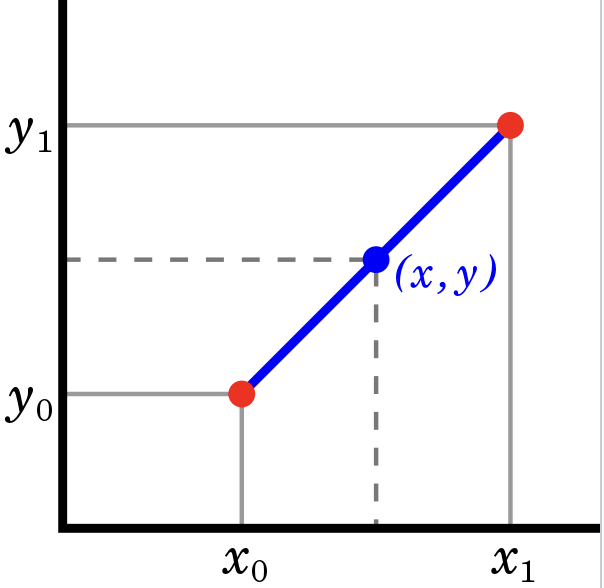

In [995]:
# 실제로 결측치라고 표시는 안되어있지만 아무 의미도 갖지 않는 element들이 아래와 같이 존재합니다.
# 아래 3가지의 경우 모두 아무 의미도 갖지 않는 element가 포함되어 있습니다.
display(concat['등기신청일자'].value_counts())

            65328
20230630      585
20230831      496
20230428      394
20230731      374
            ...  
20230105        3
20230125        3
20230109        1
20230102        1
20230104        1
Name: 등기신청일자, Length: 182, dtype: int64

In [996]:
display(concat['거래유형'].value_counts())

-       40508
중개거래    38123
직거래      3520
Name: 거래유형, dtype: int64

In [997]:
display(concat['중개사소재지'].value_counts())

-                    44070
서울 노원구                2627
서울 송파구                2540
서울 강남구                2508
서울 강동구                2038
                     ...  
서울 강북구, 서울 양천구           1
경기 남양주시, 경기 성남수정구        1
서울 송파구, 인천 계양구           1
경기 연천군, 서울 송파구           1
서울 중랑구, 인천 부평구           1
Name: 중개사소재지, Length: 739, dtype: int64

In [998]:
# GPS 정보 보정
concat['addr'] = concat['시군구'] + ' ' + concat['번지']
concat = pd.merge(concat, dt_gps, how = 'left', on='addr')
concat.head()

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,...,좌표X,좌표Y,단지신청일,target,is_test,year,quarter,addr,x,y
0,서울특별시 강남구 개포동,651-1,651.0,1.0,개포더샵트리에,105.8064,202306,29,8,2021,...,127.056394,37.484892,2022-02-23 11:05:05.0,240000.0,0,2023,2,서울특별시 강남구 개포동 651-1,127.057251,37.484830
1,서울특별시 강남구 개포동,187,187.0,0.0,개포주공5단지,74.2500,202301,3,10,1983,...,127.068028,37.487802,2013-03-07 09:46:42.0,210000.0,0,2023,1,서울특별시 강남구 개포동 187,127.068504,37.487623
2,서울특별시 강남구 개포동,187,187.0,0.0,개포주공5단지,61.1900,202302,5,12,1983,...,127.068028,37.487802,2013-03-07 09:46:42.0,199000.0,0,2023,1,서울특별시 강남구 개포동 187,127.068504,37.487623
3,서울특별시 강남구 개포동,187,187.0,0.0,개포주공5단지,83.1700,202304,7,13,1983,...,127.068028,37.487802,2013-03-07 09:46:42.0,249000.0,0,2023,2,서울특별시 강남구 개포동 187,127.068504,37.487623
4,서울특별시 강남구 개포동,187,187.0,0.0,개포주공5단지,83.1700,202304,29,10,1983,...,127.068028,37.487802,2013-03-07 09:46:42.0,277000.0,0,2023,2,서울특별시 강남구 개포동 187,127.068504,37.487623


In [999]:
concat['is_test'].value_counts()

0    72879
1     9272
Name: is_test, dtype: int64

In [1000]:
# GPS 정보 보정
concat = pd.merge(concat, dt_transport[['addr', 'subways','bus_stops']], how = 'left', on='addr')
concat.head()
concat.head()

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,...,단지신청일,target,is_test,year,quarter,addr,x,y,subways,bus_stops
0,서울특별시 강남구 개포동,651-1,651.0,1.0,개포더샵트리에,105.8064,202306,29,8,2021,...,2022-02-23 11:05:05.0,240000.0,0,2023,2,서울특별시 강남구 개포동 651-1,127.057251,37.484830,5.0,1.0
1,서울특별시 강남구 개포동,187,187.0,0.0,개포주공5단지,74.2500,202301,3,10,1983,...,2013-03-07 09:46:42.0,210000.0,0,2023,1,서울특별시 강남구 개포동 187,127.068504,37.487623,4.0,0.0
2,서울특별시 강남구 개포동,187,187.0,0.0,개포주공5단지,61.1900,202302,5,12,1983,...,2013-03-07 09:46:42.0,199000.0,0,2023,1,서울특별시 강남구 개포동 187,127.068504,37.487623,4.0,0.0
3,서울특별시 강남구 개포동,187,187.0,0.0,개포주공5단지,83.1700,202304,7,13,1983,...,2013-03-07 09:46:42.0,249000.0,0,2023,2,서울특별시 강남구 개포동 187,127.068504,37.487623,4.0,0.0
4,서울특별시 강남구 개포동,187,187.0,0.0,개포주공5단지,83.1700,202304,29,10,1983,...,2013-03-07 09:46:42.0,277000.0,0,2023,2,서울특별시 강남구 개포동 187,127.068504,37.487623,4.0,0.0


In [1001]:
concat['is_test'].value_counts()  

0    72879
1     9272
Name: is_test, dtype: int64

In [1002]:
# 시군구, 년월 등 분할할 수 있는 변수들은 세부사항 고려를 용이하게 하기 위해 모두 분할해 주겠습니다.
concat['구'] = concat['시군구'].map(lambda x : x.split()[1])
concat['동'] = concat['시군구'].map(lambda x : x.split()[2])

In [1003]:
# buy index 정보 보정
dt_buyindex = dt_buyindex.assign(year=dt_buyindex['시점'].astype('str').str[:4].astype(int))
dt_buyindex.rename(columns={'분기':'quarter', 'index_region':'buy_index'}, inplace=True)
concat = pd.merge(concat, dt_buyindex[['구', 'year', 'quarter','buy_index']], how = 'left', on=['구', 'year','quarter'])
concat.head()

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,...,year,quarter,addr,x,y,subways,bus_stops,구,동,buy_index
0,서울특별시 강남구 개포동,651-1,651.0,1.0,개포더샵트리에,105.8064,202306,29,8,2021,...,2023,2,서울특별시 강남구 개포동 651-1,127.057251,37.484830,5.0,1.0,강남구,개포동,156.2
1,서울특별시 강남구 개포동,187,187.0,0.0,개포주공5단지,74.2500,202301,3,10,1983,...,2023,1,서울특별시 강남구 개포동 187,127.068504,37.487623,4.0,0.0,강남구,개포동,147.4
2,서울특별시 강남구 개포동,187,187.0,0.0,개포주공5단지,61.1900,202302,5,12,1983,...,2023,1,서울특별시 강남구 개포동 187,127.068504,37.487623,4.0,0.0,강남구,개포동,147.4
3,서울특별시 강남구 개포동,187,187.0,0.0,개포주공5단지,83.1700,202304,7,13,1983,...,2023,2,서울특별시 강남구 개포동 187,127.068504,37.487623,4.0,0.0,강남구,개포동,156.2
4,서울특별시 강남구 개포동,187,187.0,0.0,개포주공5단지,83.1700,202304,29,10,1983,...,2023,2,서울특별시 강남구 개포동 187,127.068504,37.487623,4.0,0.0,강남구,개포동,156.2


In [1004]:
concat['is_test'].value_counts()  

0    72879
1     9272
Name: is_test, dtype: int64

In [1005]:
# 땅값 정보
dt_landprice['addr'] = dt_landprice['시도명'] + ' ' + dt_landprice['시군구명'] + ' ' + dt_landprice['소재지']
dt_landprice = dt_landprice[['addr','전년지가']].drop_duplicates(subset = ['addr'])
concat = pd.merge(concat, dt_landprice, how = 'left', on='addr')
concat['전년지가'] = concat['전년지가'].fillna(concat.groupby('시군구')['전년지가'].transform('mean'))
concat.head()

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,...,quarter,addr,x,y,subways,bus_stops,구,동,buy_index,전년지가
0,서울특별시 강남구 개포동,651-1,651.0,1.0,개포더샵트리에,105.8064,202306,29,8,2021,...,2,서울특별시 강남구 개포동 651-1,127.057251,37.484830,5.0,1.0,강남구,개포동,156.2,2.016696e+07
1,서울특별시 강남구 개포동,187,187.0,0.0,개포주공5단지,74.2500,202301,3,10,1983,...,1,서울특별시 강남구 개포동 187,127.068504,37.487623,4.0,0.0,강남구,개포동,147.4,2.016696e+07
2,서울특별시 강남구 개포동,187,187.0,0.0,개포주공5단지,61.1900,202302,5,12,1983,...,1,서울특별시 강남구 개포동 187,127.068504,37.487623,4.0,0.0,강남구,개포동,147.4,2.016696e+07
3,서울특별시 강남구 개포동,187,187.0,0.0,개포주공5단지,83.1700,202304,7,13,1983,...,2,서울특별시 강남구 개포동 187,127.068504,37.487623,4.0,0.0,강남구,개포동,156.2,2.016696e+07
4,서울특별시 강남구 개포동,187,187.0,0.0,개포주공5단지,83.1700,202304,29,10,1983,...,2,서울특별시 강남구 개포동 187,127.068504,37.487623,4.0,0.0,강남구,개포동,156.2,2.016696e+07


In [1006]:
concat['is_test'].value_counts()  

0    72879
1     9272
Name: is_test, dtype: int64

In [1007]:
# 좌표가 없는 데이터 확인
cond = concat['y'] > 36
concat[~cond]

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,...,quarter,addr,x,y,subways,bus_stops,구,동,buy_index,전년지가
334,서울특별시 강남구 개포동,138,138.0,0.0,디에이치아너힐즈,84.3558,202211,26,19,2019,...,3,서울특별시 강남구 개포동 138,NaN,NaN,0.0,0.0,강남구,개포동,171.4,2.016696e+07
335,서울특별시 강남구 개포동,138,138.0,0.0,디에이치아너힐즈,76.1709,202212,22,24,2019,...,4,서울특별시 강남구 개포동 138,NaN,NaN,0.0,0.0,강남구,개포동,148.1,2.016696e+07
336,서울특별시 강남구 개포동,138,138.0,0.0,디에이치아너힐즈,59.7479,202301,7,10,2019,...,1,서울특별시 강남구 개포동 138,NaN,NaN,0.0,0.0,강남구,개포동,147.4,2.016696e+07
337,서울특별시 강남구 개포동,138,138.0,0.0,디에이치아너힐즈,84.3558,202302,2,4,2019,...,1,서울특별시 강남구 개포동 138,NaN,NaN,0.0,0.0,강남구,개포동,147.4,2.016696e+07
338,서울특별시 강남구 개포동,138,138.0,0.0,디에이치아너힐즈,76.1709,202302,6,18,2019,...,1,서울특별시 강남구 개포동 138,NaN,NaN,0.0,0.0,강남구,개포동,147.4,2.016696e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81744,서울특별시 중구 만리동2가,176-1,176.0,1.0,서울역센트럴자이,84.9720,202308,25,7,2017,...,3,서울특별시 중구 만리동2가 176-1,NaN,NaN,0.0,0.0,중구,만리동2가,155.7,8.080000e+06
81745,서울특별시 중구 만리동2가,176-1,176.0,1.0,서울역센트럴자이,84.9720,202308,28,19,2017,...,3,서울특별시 중구 만리동2가 176-1,NaN,NaN,0.0,0.0,중구,만리동2가,155.7,8.080000e+06
81746,서울특별시 중구 만리동2가,176-1,176.0,1.0,서울역센트럴자이,84.9720,202309,1,21,2017,...,3,서울특별시 중구 만리동2가 176-1,NaN,NaN,0.0,0.0,중구,만리동2가,155.7,8.080000e+06
81747,서울특별시 중구 만리동2가,176-1,176.0,1.0,서울역센트럴자이,59.9430,202309,5,10,2017,...,3,서울특별시 중구 만리동2가 176-1,NaN,NaN,0.0,0.0,중구,만리동2가,155.7,8.080000e+06


In [1008]:
concat.shape

(82151, 64)

In [1009]:
# x, y, 전년지가, 용도지역1 채우기
#concat = concat.sort_values(by='addr', inplace=True)
#concat['x'] = concat['x'].fillna(method='ffill')
#concat['y'] = concat['y'].fillna(method='ffill')
#concat['전년지가'] = concat['전년지가'].fillna(method='ffill')
#concat['용도지역1'] = concat['용도지역1'].fillna(method='ffill')

In [1010]:
# 위 처럼 아무 의미도 갖지 않는 칼럼은 결측치와 같은 역할을 하므로, np.nan으로 채워 결측치로 인식되도록 합니다.
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)

In [1011]:
# EDA에 앞서 결측치를 확인해보겠습니다.
concat.isnull().sum()

시군구             0
번지             24
본번              8
부번              8
아파트명          296
             ... 
bus_stops      24
구               0
동               0
buy_index       0
전년지가         7378
Length: 64, dtype: int64

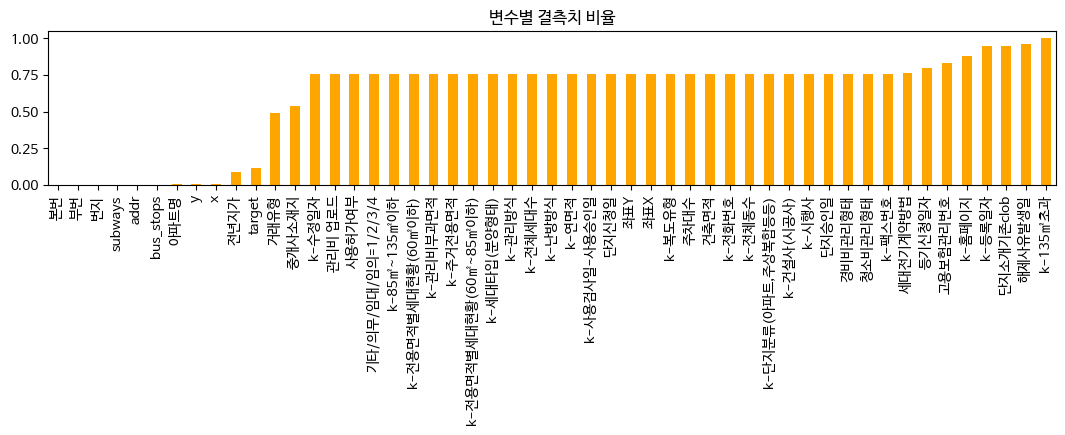

In [1012]:
# 변수별 결측치의 비율을 plot으로 그려보면 아래와 같습니다.
fig = plt.figure(figsize=(13, 2))
missing = concat.isnull().sum() / concat.shape[0]
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

- 위 그래프에서 볼 수 있다시피 결측치가 100만개 이상인 칼럼들은 결측치가 해당 칼럼의 element 중 90% 이상을 차지하는 상황이 됩니다.
- 따라서 본 Baseline 에서는 이 칼럼은 예측에 도움이 되지 않는다고 판단해 삭제해주도록 하겠습니다.

In [1013]:
# Null값이 100만개 이상인 칼럼은 삭제해보도록 하겠습니다.
print("* 결측치가 100만개 이하인 변수들 :", list(concat.columns[concat.isnull().sum() <= 1000000]))     # 남겨질 변수들은 아래와 같습니다.
print("* 결측치가 100만개 이상인 변수들 :", list(concat.columns[concat.isnull().sum() >= 1000000]))

* 결측치가 100만개 이하인 변수들 : ['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target', 'is_test', 'year', 'quarter', 'addr', 'x', 'y', 'subways', 'bus_stops', '구', '동', 'buy_index', '전년지가']
* 결측치가 100만개 이상인 변수들 : []


In [1014]:
# 위에서 결측치가 100만개 이하인 변수들만 골라 새로운 concat_select 객체로 저장해줍니다.
selected = list(concat.columns[concat.isnull().sum() <= 1000000])
concat_select = concat[selected]

In [1015]:
concat_select.isnull().sum()     # 결측치가 100만개 초과인 칼럼이 제거된 모습은 아래와 같습니다.
# target변수는 test dataset 개수만큼(9272) 결측치가 존재함을 확인할 수 있습니다.

시군구             0
번지             24
본번              8
부번              8
아파트명          296
             ... 
bus_stops      24
구               0
동               0
buy_index       0
전년지가         7378
Length: 64, dtype: int64

In [1016]:
# 연속형 변수는 선형보간을 해주고, 범주형변수는 알수없기에 “unknown”이라고 임의로 보간해 주겠습니다.
concat_select.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82151 entries, 0 to 82150
Data columns (total 64 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   시군구                     82151 non-null  object 
 1   번지                      82127 non-null  object 
 2   본번                      82143 non-null  float64
 3   부번                      82143 non-null  float64
 4   아파트명                    81855 non-null  object 
 5   전용면적                    82151 non-null  float64
 6   계약년월                    82151 non-null  int64  
 7   계약일                     82151 non-null  int64  
 8   층                       82151 non-null  int64  
 9   건축년도                    82151 non-null  int64  
 10  도로명                     82151 non-null  object 
 11  해제사유발생일                 3058 non-null   float64
 12  등기신청일자                  16823 non-null  object 
 13  거래유형                    41643 non-null  object 
 14  중개사소재지                  38081 non-null

In [1017]:
# 본번, 부번의 경우 float로 되어있지만 범주형 변수의 의미를 가지므로 object(string) 형태로 바꾸어주고 아래 작업을 진행하겠습니다.
concat_select['본번'] = concat_select['본번'].astype('str')
concat_select['부번'] = concat_select['부번'].astype('str')

In [1018]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적', '계약년월', '계약일', '층', '건축년도', '해제사유발생일', '단지소개기존clob', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', 'is_test', 'year', 'quarter', 'x', 'y', 'subways', 'bus_stops', 'buy_index', '전년지가']
범주형 변수: ['시군구', '번지', '본번', '부번', '아파트명', '도로명', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일', 'addr', '구', '동']


- 연속형 변수와 범주형 변수가 알맞게 나누어졌는지 확인해보고, 이제 각각 보간을 진행합니다.

In [1019]:
# 범주형 변수에 대한 보간
concat_select[categorical_columns] = concat_select[categorical_columns].fillna('NULL')

# 연속형 변수에 대한 보간 (선형 보간)
concat_select[continuous_columns] = concat_select[continuous_columns].interpolate(method='linear', axis=0)

In [1020]:
%%time
# 빈값 데이터 일치시킴
# 5분 소요됨
#columns = ['k-전체동수','k-전체세대수','k-연면적','k-주거전용면적','k-관리비부과면적',
#           'k-전용면적별세대현황(60㎡이하)','k-전용면적별세대현황(60㎡~85㎡이하)','k-85㎡~135㎡이하','건축면적','주차대수']
#
#for column in columns:
#    print(column)
#    concat_select[column] = concat_select.groupby(['아파트명', '전용면적', '층'])[column].transform(lambda x:x.mode()[0])

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.3 µs


In [1021]:
concat_select.isnull().sum()         # 결측치가 보간된 모습을 확인해봅니다.

시군구          0
번지           0
본번           0
부번           0
아파트명         0
            ..
bus_stops    0
구            0
동            0
buy_index    0
전년지가         0
Length: 64, dtype: int64

- Baseline에서는 단순 결측치들을 제거하거나 보간했지만,
EDA를 통해 변수들의 흐름을 조금 더 파악하고 더 나은 interpolation 등의 방법을 고려해볼 수 있을 것 같습니다.

### 3.2. 이상치 처리
- 이번엔 이상치를 처리해봅시다.
- 이상치를 처리하는 방법은 IQR, Z-score 등 다양한 방법이 있습니다. 가장 쉽고 직관적으로 접근하는 방법은 기본 통계치를 이용하는 것입니다.
- 본 baseline에서는 IQR를 이용한 방법을 사용하겠습니다.

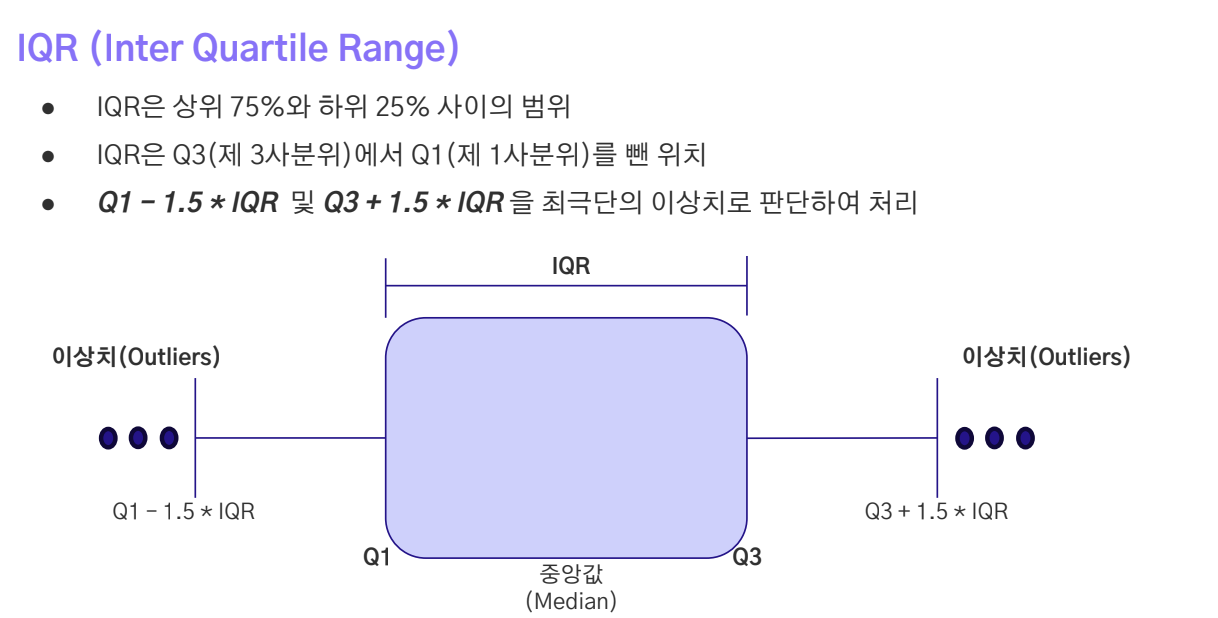

In [1022]:
# 이상치 제거 이전의 shape은 아래와 같습니다.
print(concat_select.shape)

(82151, 64)


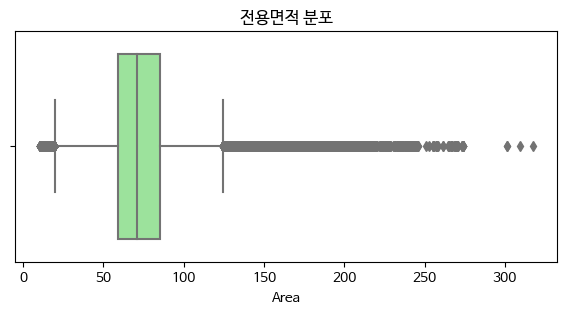

In [1023]:
# 대표적인 연속형 변수인 “전용 면적” 변수 관련한 분포를 먼저 살펴보도록 하겠습니다.
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = concat_select, x = "전용면적", color="lightgreen")
plt.title("전용면적 분포")
plt.xlabel("Area")
plt.show()

In [1024]:
# 이상치 제거 방법에는 IQR을 이용하겠습니다.
def remove_outliers_iqr(dt, column_name):
    df = dt.query('is_test == 0')       # train data 내에 있는 이상치만 제거하도록 하겠습니다.
    df_test = dt.query('is_test == 1')

    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    result = pd.concat([df, df_test])   # test data와 다시 합쳐주겠습니다.
    return result

In [1025]:
# 위 방법으로 전용 면적에 대한 이상치를 제거해보겠습니다.
concat_select = remove_outliers_iqr(concat_select, '전용면적')

In [1026]:
# 이상치 제거 후의 shape은 아래와 같습니다. 약 10만개의 데이터가 제거된 모습을 확인할 수 있습니다.
print(concat_select.shape)

(74250, 64)


In [1027]:
concat_select['is_test'].value_counts()     # 또한, train data만 제거되었습니다.

0    64978
1     9272
Name: is_test, dtype: int64

In [1028]:
cond1 = concat_select['아파트명'] == '로얄하이츠'
cond2 = concat_select['계약년월'] == '200802'
concat_select[cond1 & cond2]

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,...,quarter,addr,x,y,subways,bus_stops,구,동,buy_index,전년지가


In [1029]:
# 오차가 많이발생하는 10개 row 삭제
#index_list = [1123216, 966318, 1066520, 825602, 17774, 2814, 2741, 13928, 1066901, 674574]
#index_list = [138, 537, 599, 1138, 1284, 1481, 2741, 2781, 2814, 4031,
#            5266, 6617, 9744, 10640, 13080, 13928, 17774, 18144, 18623, 26020,
#            27544, 28441, 32948, 35932, 36769, 37152, 37507, 37943, 44141, 44152, 
#            46756, 47683, 47684, 48333, 48713, 50357, 50465, 52597, 55418, 55447, 
#            55490, 57063, 57078, 65175, 66608, 66658,  84581, 604063, 643457, 646233, 
#            655888, 656518, 656621, 656674, 656682, 657279, 664237, 664255, 674574, 675089, 
#            684520, 687127, 688566, 688624, 690021, 694421, 695584, 695666, 707992, 814850, 
#            820959, 825602, 840939, 848353, 848569, 897069, 962284, 965892, 966318, 967783, 
#            968557, 970525, 976360, 1007780, 1021798, 1066054, 1066130, 1066511, 1066520, 1066901, 
#            1068519, 1068996, 1085349, 1099323, 1099324, 1099895, 1106086, 1112623, 1112689, 1123216 ]
#concat_select.loc[index_list]
#concat_select.drop(index=index_list, inplace=True)

In [1030]:
#worst_data_path = ['output/worst_data_20240119212831.csv', 'output/worst_data_20240119231854.csv']
#worst_data_path = ['output/worst_data_20240119235729.csv']
#for file_name in worst_data_path:
#    worst_data = pd.read_csv(file_name, encoding='EUC-KR')
#    worst_data_list = list(worst_data['Unnamed: 0'])
#    concat_select.drop(index=worst_data_list, inplace=True)    

## 4. Feature Engineering
- 이제 파생변수를 만들어보도록 하겠습니다.
- 파생 변수는 도메인 지식에 기반해 제작하는 것이 중요합니다.
- 주택의 가격을 예측하는 문제이기 때문에 약간의 부동산 지식을 기반으로 파생 변수를 만들어 보도록 하겠습니다.

In [1031]:
#concat_select['계약월'] = concat_select['계약년월'].astype('str').map(lambda x : x[4:])
#concat_select['계약년월'] = concat_select[['계약년월', '계약일']].apply(lambda x: ''.join(x), axis=1)

# 계약연월일 생성
concat_select['계약년월'] = concat_select['계약년월'].astype(str)
concat_select['계약일'] = concat_select['계약일'].astype(str)
concat_select['계약일'] = concat_select['계약일'].apply(lambda x: "0" + x if len(x) == 1 else x)
concat_select['계약년월일'] = concat_select[['계약년월', '계약일']].apply(lambda x: ''.join(x), axis=1)
#concat_select['계약년월일'] = pd.to_datetime(concat_select['계약년월일'] )
concat_select['계약년월일'] = concat_select['계약년월일'].astype(int)

# del concat_select['계약년월']
del concat_select['계약일']


In [1032]:
concat_select.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '층', '건축년도', '도로명',
       '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호',
       'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식',
       'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적',
       'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)',
       'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호',
       '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4',
       '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target',
       'is_test', 'year', 'quarter', 'addr', 'x', 'y', 'subways', 'bus_stops',
       '구', '동', 'buy_index', '전년지가', '계약년월일'],
      dtype='object')

- 서울의 집값은 강남, 강북 여부에 따라 차이가 많이 난다는 사실은 많이 알려진 사실입니다.
- 따라서 강남/강북의 여부에 따라 파생변수를 생성해주도록 하겠습니다.

In [1033]:
all = list(concat_select['구'].unique())
gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
gangbuk = [x for x in all if x not in gangnam]

assert len(all) == len(gangnam) + len(gangbuk)       # 알맞게 분리되었는지 체크합니다.

In [1034]:
# 강남의 여부를 체크합니다.
is_gangnam = []
for x in concat_select['구'].tolist() :
  if x in gangnam :
    is_gangnam.append(1)
  else :
    is_gangnam.append(0)

# 파생변수를 하나 만릅니다.
concat_select['강남여부'] = is_gangnam

In [1035]:
concat_select.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '층', '건축년도', '도로명',
       '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호',
       'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식',
       'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적',
       'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)',
       'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호',
       '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4',
       '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target',
       'is_test', 'year', 'quarter', 'addr', 'x', 'y', 'subways', 'bus_stops',
       '구', '동', 'buy_index', '전년지가', '계약년월일', '강남여부'],
      dtype='object')

- 또한 신축인지, 구축인지의 여부도 실거래가에 큰 영향을 줄 수 있습니다.
- 따라서 건축년도에 따라 파생변수를 제작해주도록 하겠습니다.

In [1036]:
# 건축년도 분포는 아래와 같습니다. 특히 2005년이 Q3에 해당합니다.
# 2009년 이후에 지어진 건물은 10%정도 되는 것을 확인할 수 있습니다.
concat_select['건축년도'].describe(percentiles = [0.1, 0.25, 0.5, 0.75, 0.8, 0.9])

count    74250.000000
mean      2002.327017
std         10.805303
min       1961.000000
10%       1988.000000
25%       1995.000000
50%       2002.000000
75%       2010.000000
80%       2013.000000
90%       2018.000000
max       2023.000000
Name: 건축년도, dtype: float64

In [1037]:
# 따라서 2009년 이후에 지어졌으면 비교적 신축이라고 판단하고, 신축 여부 변수를 제작해보도록 하겠습니다.
concat_select['신축여부'] = concat_select['건축년도'].apply(lambda x: 1 if x >= 2009 else 0)
concat_select['재건축'] = concat_select['건축년도'].apply(lambda x: 1 if x < 1990 else 0)

In [1038]:
concat_select.head(1)       # 최종 데이터셋은 아래와 같습니다.

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,층,건축년도,도로명,...,subways,bus_stops,구,동,buy_index,전년지가,계약년월일,강남여부,신축여부,재건축
0,서울특별시 강남구 개포동,651-1,651.0,1.0,개포더샵트리에,105.8064,202306,8,2021,개포로 311,...,5.0,1.0,강남구,개포동,156.2,2.016696e+07,20230629,1,1,0


In [1039]:
concat_select.shape

(74250, 67)

In [1040]:
#concat_select['거래량_구'] =  concat_select.groupby(['구','계약년'])['계약년'].transform(lambda x: x.count())

In [1041]:
#concat_select['거래량_동'] =  concat_select.groupby(['동','계약년'])['계약년'].transform(lambda x: x.count())

In [1042]:
concat_select['거래량_년월동'] =  concat_select.groupby(['동','계약년월'])['계약년월'].transform(lambda x: x.count())

In [1043]:
# 동일 시공사 명칭으로 변경
# concat_select['k-건설사(시공사)'] = concat_select['k-건설사(시공사)'].str.replace('\(주\)','')
# concat_select['k-건설사(시공사)'] = concat_select['k-건설사(시공사)'].str.replace('건설','')
# concat_select['k-건설사(시공사)'] = concat_select['k-건설사(시공사)'].str.replace('물산','')
# concat_select['k-건설사(시공사)'] = concat_select['k-건설사(시공사)'].str.replace(' 택부문','')
# concat_select['k-건설사(시공사)'] = concat_select['k-건설사(시공사)'].str.replace('LG','GS')
# concat_select['k-건설사(시공사)'] = concat_select['k-건설사(시공사)'].str.replace('선경','SK')
# concat_select['k-건설사(시공사)'] = concat_select['k-건설사(시공사)'].str.replace(' ','')

In [1044]:
# top 10 시공사 아파트 여부를 나타내는 컬럼 생성
# concat_select['top10'] = 0
top10 = ['자이', '푸르지오', '더샵', '롯데캐슬', '이편한|e편한|e-편한',
         '힐스테이트', '아이파크', '래미안', 'sk|SK|에스케이', '데시앙']

# # top 10 시공사면 1, 아니면 0
# for i, brand in enumerate(top10):
#     concat_select.loc[concat_select['아파트명'].str.contains(brand), 'top10'] = 1

# concat_select['top10'].value_counts()

In [1045]:
# 데이터에 많이 있는 아파트 대표 25개 리스트
apt_names = ['그레이스', '양지', '쌍용', '현대', '한신', '삼성', '대우', '신동아', '두산', '주공',
             '우성', '벽산', '동원로얄듀크','경남', '삼환', '쌍용', '삼익', '대림', '코오롱', '파크리오',
             '엘지', '성원', '잠실', '동궁리치웰', '동성']
# top 10 시공사 키워드와 25개 리스트를 통합
apt_names_list = top10 + apt_names

concat_select['브랜드'] = 'others'
for brand in tqdm(apt_names_list):
    concat_select.loc[concat_select['아파트명'].str.contains(brand), '브랜드'] = brand

100%|██████████| 35/35 [00:00<00:00, 58.03it/s]


In [1046]:
# 용적율 추가 - 의미 없음
# concat_select['용적율'] = (concat_select['k-주거전용면적'] / concat_select['k-연면적']) * 100

# 평당가격 추가 - Overfit Feature
# concat_select['평당가격'] = (concat_select['target'] / concat_select['k-주거전용면적'])

In [1047]:
# 월별 평균가격 추출 - Overfitting
#apt_avg_price_df = concat_select.groupby(['아파트명', '전용면적', '층','계약년월'])['target'].mean().reset_index()
#apt_avg_price_df.rename(columns={"target":"월별평균가격"}, inplace=True)
#concat_select = pd.merge(concat_select, apt_avg_price_df, on = ['아파트명', '전용면적', '층','계약년월'])
#`concat_select.head(2)

In [1048]:
# 계약시 건물년수
concat_select['건물년수'] = concat_select['계약년월일'] // 10000 -  concat_select['건축년도']

In [1049]:
concat_select.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '층', '건축년도', '도로명',
       '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호',
       'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식',
       'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적',
       'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)',
       'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호',
       '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4',
       '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target',
       'is_test', 'year', 'quarter', 'addr', 'x', 'y', 'subways', 'bus_stops',
       '구', '동', 'buy_index', '전년지가', '계약년월일', '강남여부', '신축여부', '재건축',
       '거래량_년월동', '브랜드', '건물년수'],
      dtype='object')

In [1050]:
#concat_select['year_avg_price'] = concat_select.groupby(['동', '아파트명', '전용면적','year'])['target'].transform('mean')
#concat_select['year_max_price'] = concat_select.groupby([ '동', '아파트명', '전용면적','year'])['target'].transform('max')
concat_select['year_avg_price'] = concat_select.groupby(['아파트명', '전용면적','year'])['target'].transform('mean')
concat_select['year_max_price'] = concat_select.groupby(['아파트명', '전용면적','year'])['target'].transform('max')
concat_select['price_ratio'] = (concat_select['year_max_price'] - concat_select['year_avg_price']) / concat_select['year_max_price']

In [1051]:
df_apartment_price = concat_select.groupby(['동', '아파트명', '전용면적','year'])['target'].agg([np.mean, max]).reset_index()
df_apartment_price.head()
#df_apartment_price.to_csv('output/apartment_price_data.csv', encoding='EUC-KR')

,동,아파트명,전용면적,year,mean,max
0,가락동,e지브로,84.78,2021,77000.0,77000.0
1,가락동,sk파크타워,84.35,2021,107000.0,107000.0
2,가락동,sk파크타워,84.85,2023,88000.0,88000.0
3,가락동,"가락3차쌍용스윗닷홈101동,102동",59.94,2021,112500.0,115000.0
4,가락동,"가락3차쌍용스윗닷홈101동,102동",84.99,2023,110000.0,110000.0


In [1052]:
cond = concat_select['price_ratio'] >= 0.2
concat_select[cond].head(100)

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,층,건축년도,도로명,...,계약년월일,강남여부,신축여부,재건축,거래량_년월동,브랜드,건물년수,year_avg_price,year_max_price,price_ratio
1,서울특별시 강남구 개포동,187,187.0,0.0,개포주공5단지,74.250,202301,10,1983,삼성로4길 17,...,20230103,1,0,1,32,주공,40,181000.000000,245000.0,0.261224
5,서울특별시 강남구 개포동,187,187.0,0.0,개포주공5단지,74.250,202305,5,1983,삼성로4길 17,...,20230516,1,0,1,44,주공,40,181000.000000,245000.0,0.261224
10,서울특별시 강남구 개포동,185,185.0,0.0,개포주공6단지,53.060,202305,1,1983,개포로 516,...,20230513,1,0,1,44,주공,40,134000.000000,180000.0,0.255556
17,서울특별시 강남구 개포동,1280,1280.0,0.0,래미안블레스티지,59.897,202301,5,2019,선릉로 8,...,20230112,1,1,0,32,래미안,4,127700.000000,167400.0,0.237157
21,서울특별시 강남구 개포동,1280,1280.0,0.0,래미안블레스티지,84.943,202302,10,2019,선릉로 8,...,20230204,1,1,0,44,래미안,4,205500.000000,270000.0,0.238889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,서울특별시 강남구 대치동,316,316.0,0.0,은마,76.790,202304,7,1979,삼성로 212,...,20230405,1,0,1,25,others,44,174104.918033,230000.0,0.243022
280,서울특별시 강남구 대치동,316,316.0,0.0,은마,76.790,202304,8,1979,삼성로 212,...,20230410,1,0,1,25,others,44,174104.918033,230000.0,0.243022
281,서울특별시 강남구 대치동,316,316.0,0.0,은마,84.430,202304,3,1979,삼성로 212,...,20230410,1,0,1,25,others,44,185095.000000,256000.0,0.276973
282,서울특별시 강남구 대치동,316,316.0,0.0,은마,76.790,202304,13,1979,삼성로 212,...,20230412,1,0,1,25,others,44,174104.918033,230000.0,0.243022


In [1053]:
# 가격이 20%이상 차이날 경우 가격 조정함
weight = 1.0
base_ratio = 0.2
cond = concat_select['price_ratio'] >= base_ratio
#concat_select['year_avg_price'] = concat_select.apply(lambda x: x['year_max_price'] * weight if x['price_ratio'] >= base_ratio else x['year_avg_price'], axis=1)
#concat_select[cond].to_csv('output/ratio_data.csv', encoding='EUC-KR')
concat_select[cond].head()

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,층,건축년도,도로명,...,계약년월일,강남여부,신축여부,재건축,거래량_년월동,브랜드,건물년수,year_avg_price,year_max_price,price_ratio
1,서울특별시 강남구 개포동,187,187.0,0.0,개포주공5단지,74.250,202301,10,1983,삼성로4길 17,...,20230103,1,0,1,32,주공,40,245000.0,245000.0,0.261224
5,서울특별시 강남구 개포동,187,187.0,0.0,개포주공5단지,74.250,202305,5,1983,삼성로4길 17,...,20230516,1,0,1,44,주공,40,245000.0,245000.0,0.261224
10,서울특별시 강남구 개포동,185,185.0,0.0,개포주공6단지,53.060,202305,1,1983,개포로 516,...,20230513,1,0,1,44,주공,40,180000.0,180000.0,0.255556
17,서울특별시 강남구 개포동,1280,1280.0,0.0,래미안블레스티지,59.897,202301,5,2019,선릉로 8,...,20230112,1,1,0,32,래미안,4,167400.0,167400.0,0.237157
21,서울특별시 강남구 개포동,1280,1280.0,0.0,래미안블레스티지,84.943,202302,10,2019,선릉로 8,...,20230204,1,1,0,44,래미안,4,270000.0,270000.0,0.238889


In [1054]:
concat_select.shape

(74250, 73)

In [1055]:
# feature 이름이 문제가 있을 경우 LGBM이 오류를 발생시킴
concat_select.rename(columns={'k-단지분류(아파트,주상복합등등)':'k-단지분류', 'k-세대타입(분양형태)':'k-세대타입',
                         'k-건설사(시공사)':'k-건설사', 'k-전용면적별세대현황(60㎡이하)':'k-전용면적1', 
                         'k-전용면적별세대현황(60㎡~85㎡이하)':'k-전용면적2', 'k-85㎡~135㎡이하':'k-전용면적3', 
                         '기타/의무/임대/임의=1/2/3/4':'임대방식'}, inplace=True)
concat_select.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '층', '건축년도', '도로명',
       '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류', 'k-전화번호', 'k-팩스번호',
       '단지소개기존clob', 'k-세대타입', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수',
       'k-전체세대수', 'k-건설사', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적',
       'k-관리비부과면적', 'k-전용면적1', 'k-전용면적2', 'k-전용면적3', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '임대방식', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y',
       '단지신청일', 'target', 'is_test', 'year', 'quarter', 'addr', 'x', 'y',
       'subways', 'bus_stops', '구', '동', 'buy_index', '전년지가', '계약년월일', '강남여부',
       '신축여부', '재건축', '거래량_년월동', '브랜드', '건물년수', 'year_avg_price',
       'year_max_price', 'price_ratio'],
      dtype='object')

In [1056]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
drop_list = ["k-단지분류","k-전화번호","k-팩스번호", "k-세대타입", "k-관리방식",
             "k-복도유형", "k-난방방식",'k-수정일자', '고용보험관리번호', '경비비관리형태', 
             '세대전기계약방법', '청소비관리형태', "임대방식",  "단지승인일", "사용허가여부", 
             "관리비 업로드", "단지신청일", "좌표X", "좌표Y", "addr", 
             'k-135㎡초과', "등기신청일자", "거래유형", "중개사소재지", "k-건설사", 
             "k-시행사", "k-사용검사일-사용승인일", "k-홈페이지", "k-등록일자",
             "계약년월일", "해제사유발생일",
             "단지소개기존clob", '본번', '부번',
             'k-전용면적1', 'k-전용면적2', 'k-전용면적3', 'k-관리비부과면적'
             ]

concat_select.drop(columns=drop_list, inplace=True)

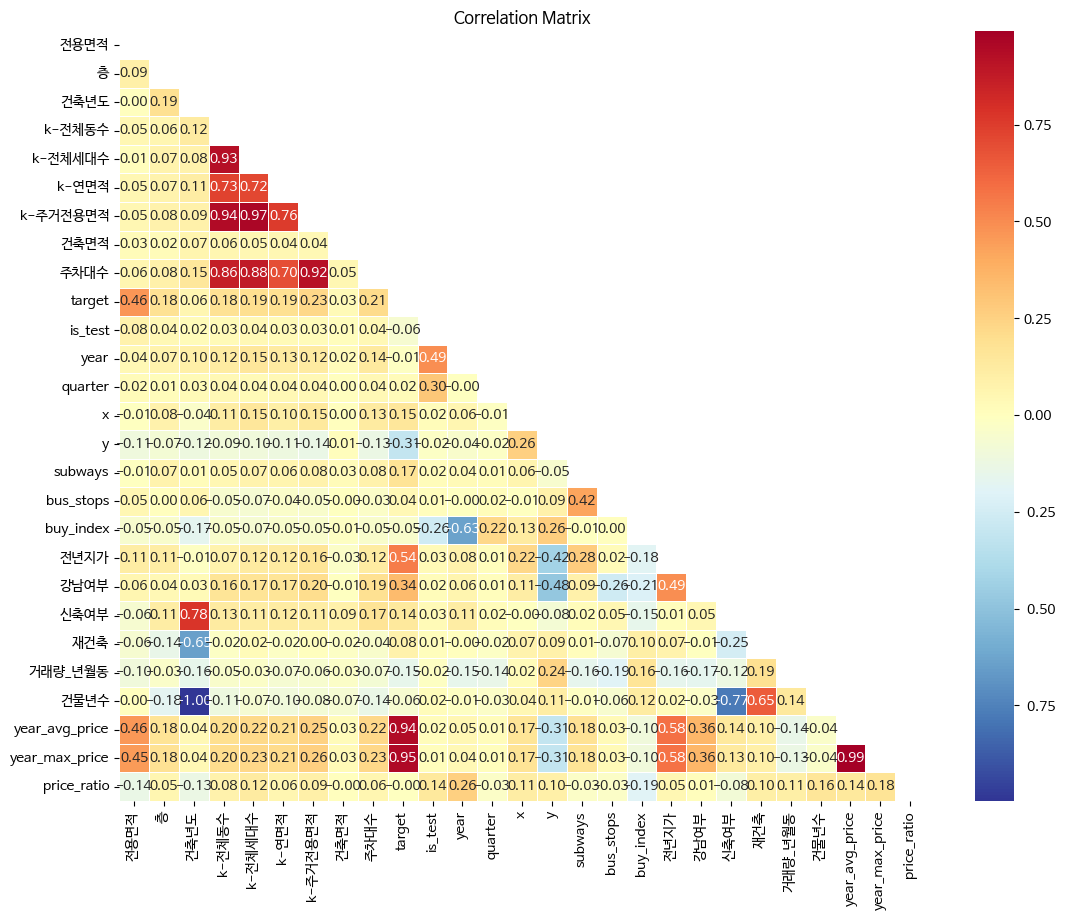

In [1057]:
# 데이터의 상관계수 행렬을 생성
corr = concat_select.corr(numeric_only=True)

# figure에서 생략될 부분을 지정하는 mask 행렬을 생성
mask = np.ones_like(corr, dtype=bool)
mask = np.triu(mask)

# 시각화될 그림의 크기를 지정
# 히트맵 형태로 상관행렬 시각화하기
plt.figure(figsize=(13,10))
sns.heatmap(data=corr, annot=True, fmt='.2f', mask=mask, linewidths=.5, cmap='RdYlBu_r')
plt.title('Correlation Matrix')
plt.show()

- 위 두 사항 외에도 외부 공공 데이터를 이용하거나, EDA를 통해 더 많은 변수를 제작할 수 있습니다.

## 5. Model Training

- 이제 위에서 만든 파생변수들과 정제한 데이터를 기반으로 본격적으로 부동산 실거래가를 예측하는 모델링을 진행하겠습니다.
- 모델링에는 `sklearn`의 `RandomForest`를 이용하도록 하겠습니다.

- 참고 ✅
  - `RandomForest`는 배깅(Bagging)의 일종으로, 학습시키는 데이터 뿐 아니라 특성변수(X)들도 무작위로 선택해 트리를 생성하는 방법입니다.
  - 모델 학습 과정에서 서로 다른 N개의 Tree 생성하고, N개의 Tree에서 발생한 Output을 Voting(범주형, 분류문제)하거나, Average(연속형, 회귀문제)해 최종 Output 생성합니다.
  - 이는 High variance, Low bias 상황에서 분산(Variance) 감소에 도움을 줍니다.

In [1058]:
# Target 값을 변경
#concat_select['target_org'] = concat_select['target']
concat_select['target'] = concat_select['year_avg_price']
concat_select.drop(['year_avg_price'], axis = 1, inplace=True)


dt_train = concat_select.query('is_test==0')
dt_test = concat_select.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(64978, 33) (9272, 33)


In [1059]:
dt_test.head(1)

,시군구,번지,아파트명,전용면적,계약년월,층,건축년도,도로명,k-전체동수,k-전체세대수,...,buy_index,전년지가,강남여부,신축여부,재건축,거래량_년월동,브랜드,건물년수,year_max_price,price_ratio
72879,서울특별시 강남구 개포동,658-1,개포6차우성,79.97,202307,5,1987,언주로 3,8.0,270.0,...,156.2,2.016696e+07,1,0,1,42,우성,36,88000.0,0.0


In [1060]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

### 5.1. 범주형 변수 Encoding
- 범주형 변수는 그대로 모델에 투입하면, 모델이 제대로 작동할 수 없습니다.
- 따라서 **레이블 인코딩 과정**을 통해 범주형 변수들을 numeric하게 바꾸는 인코딩 과정을 진행해주도록 하겠습니다.

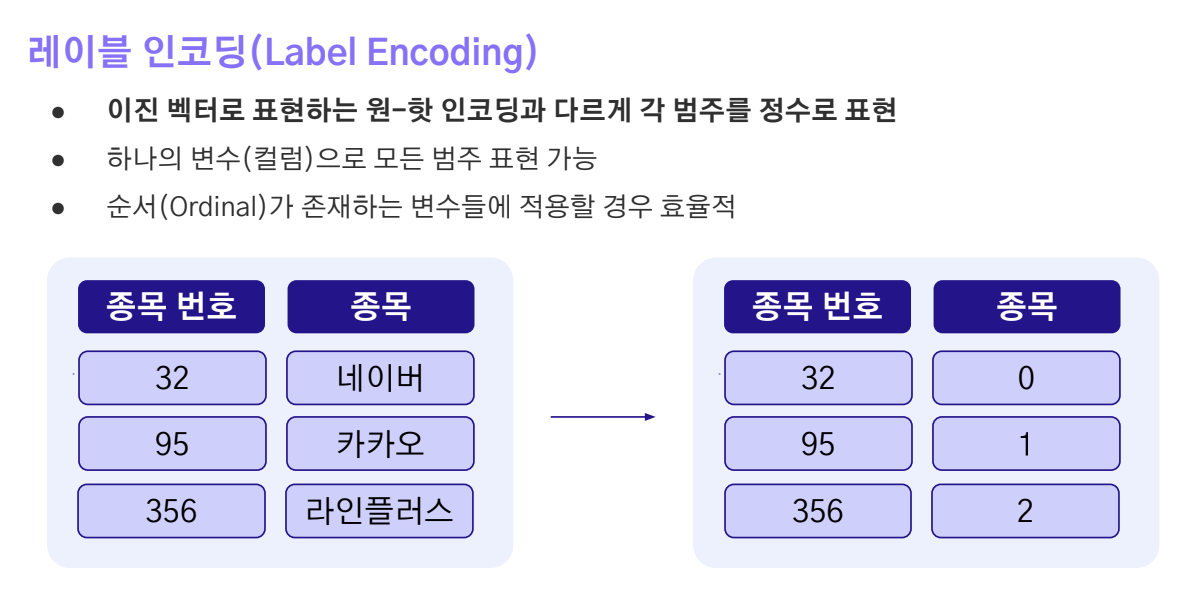

In [1061]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', '건축면적', '주차대수', 'target', 'year', 'quarter', 'x', 'y', 'subways', 'bus_stops', 'buy_index', '전년지가', '강남여부', '신축여부', '재건축', '거래량_년월동', '건물년수', 'year_max_price', 'price_ratio']
범주형 변수: ['시군구', '번지', '아파트명', '계약년월', '도로명', '구', '동', '브랜드']


In [1062]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

100%|██████████| 8/8 [00:00<00:00, 13.50it/s]


In [1063]:
dt_train.head(1)        # 레이블인코딩이 된 모습입니다.

,시군구,번지,아파트명,전용면적,계약년월,층,건축년도,도로명,k-전체동수,k-전체세대수,...,buy_index,전년지가,강남여부,신축여부,재건축,거래량_년월동,브랜드,건물년수,year_max_price,price_ratio
0,0,3124,242,105.8064,29,8,2021,292,2.0,232.0,...,156.2,2.016696e+07,1,1,0,49,6,2,240000.0,0.0


### 5.2. Model Training
- 위 데이터를 이용해 모델을 train 해보겠습니다. 모델은 RandomForest를 이용하겠습니다.
- Train과 Valid dataset을 분할하는 과정에서는 `holdout` 방법을 사용하겠습니다. 이 방법의 경우  대략적인 성능을 빠르게 확인할 수 있다는 점에서 baseline에서 사용해보도록 하겠습니다.
  - 이 후 추가적인 eda를 통해서 평가세트와 경향을 맞추거나 kfold와 같은 분포에 대한 고려를 추가할 수 있습니다.

In [1064]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

In [1065]:
# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.05, random_state=2023)

In [1066]:
def optimizer(trial):
    # 조절할 hyper-parameter 조합을 적어줍니다.
    # bayesian optimization을 이용함
    #num_leaves = trial.suggest_categorical('num_leaves', [63, 127, 255, 511, 1023, 2047]) 
    num_leaves = trial.suggest_int('num_leaves', 30, 5000) 
    max_depth =  trial.suggest_int('max_depth', 10, 30) 
    learning_rate =  trial.suggest_float('learning_rate', 0.01, 0.1) # 최소값 : 5, 최대값 : 10
    n_estimators =  trial.suggest_int('n_estimators', 100, 600)
    min_child_samples = trial.suggest_int('min_child_samples', 10, 50)
    reg_lambda =  trial.suggest_int('reg_lambda', 0.5, 100)
    colsample_bytree =  trial.suggest_float('colsample_bytree', 0.5, 0.8)

    # 원하는 모델을 지정합니다, optuna는 시간이 오래걸리기 때문에 저는 보통 RF로 일단 테스트를 해본 뒤에 LGBM을 사용합니다.
    model = LGBMRegressor(
                            num_leaves=num_leaves,
                            max_depth=max_depth,
                            learning_rate=learning_rate,
                            n_estimators=n_estimators,
                            min_child_samples=min_child_samples,
                            reg_lambda=reg_lambda,
                            colsample_bytree=colsample_bytree, # 피쳐 갯수 * colsample_bytree
                            random_state=42,
                            verbose=-1 # 설정하지 않을 경우 경고 많이 나옴
                            )
    
    # model = LGBMRegressor(
    #                         num_leaves=63,
    #                         max_depth=max_depth,
    #                         learning_rate=learning_rate,
    #                         n_estimators=n_estimators,
    #                         min_child_samples=min_child_samples,
    #                         reg_lambda=reg_lambda,
    #                         colsample_bytree=colsample_bytree, # 피쳐 갯수 * colsample_bytree
    #                         random_state=42,
    #                         verbose=-1 # 설정하지 않을 경우 경고 많이 나옴
    #                         )    

    evaluation_metric = mean_squared_error
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    score = evaluation_metric(y_val, preds)

    return score

# BEST PARAM 목록

In [1067]:
# 20938052.837617226 {'num_leaves': 1023, 'max_depth': 11, 'learning_rate': 0.06807367411269566, 'n_estimators': 485, 'min_child_samples': 18, 'min_samples_leaf': 17, 'max_features': 0.5106518214914378}
# Best Score: 17678988.3522
# Best params:  {'num_leaves': 3480, 'max_depth': 15, 'learning_rate': 0.06033866021159148, 'n_estimators': 425, 'min_child_samples': 12, 'min_samples_leaf': 3, 'max_features': 0.5560840335514822}
# Best Score: 17531816.2218
# Best params:  {'num_leaves': 4849, 'max_depth': 15, 'learning_rate': 0.06509124154720337, 'n_estimators': 500, 'min_child_samples': 14, 'reg_lambda': 12, 'colsample_bytree': 0.6330933368699972}
# Best Score: 17640178.0743
# Best params:  {'num_leaves': 3792, 'max_depth': 14, 'learning_rate': 0.07387680655849116, 'n_estimators': 488, 'min_child_samples': 10, 'reg_lambda': 11, 'colsample_bytree': 0.6431802345668778}
# Best Score: 17023184.7665
# Best params: {'num_leaves': 2036, 'max_depth': 19, 'learning_rate': 0.066259794360661, 'n_estimators': 591, 'min_child_samples': 13, 'reg_lambda': 4, 'colsample_bytree': 0.6666213307554029}
# Best Score: 17497319.0119
# Best params:  {'num_leaves': 2187, 'max_depth': 16, 'learning_rate': 0.07030910055941099, 'n_estimators': 586, 'min_child_samples': 28, 'reg_lambda': 5, 'colsample_bytree': 0.6295870328223518}
# Best Score: 14469266.5317
# Best params:  {'num_leaves': 4115, 'max_depth': 26, 'learning_rate': 0.0427930821653709, 'n_estimators': 556, 'min_child_samples': 18, 'reg_lambda': 9, 'colsample_bytree': 0.6875688234500681}
# Best Score: 29173724.7146
# Best params:  {'num_leaves': 3684, 'max_depth': 23, 'learning_rate': 0.0625677648049764, 'n_estimators': 562, 'min_child_samples': 33, 'reg_lambda': 27, 'colsample_bytree': 0.5895991623458734}

In [1068]:
# 최소/최대 어느 방향의 최적값을 구할 건지.
# evaluation_metric이 mean_squared_error일 경우 낮을수록 좋으므로 minimize가 맞음
study = optuna.create_study(direction="minimize") 
study.optimize(optimizer, n_trials=10)

[I 2024-01-25 12:55:04,440] A new study created in memory with name: no-name-33fb89b3-abec-438a-be11-fc7c2c9b2499


[I 2024-01-25 12:55:11,774] Trial 0 finished with value: 10064559.3043517 and parameters: {'num_leaves': 1622, 'max_depth': 20, 'learning_rate': 0.02688185184616028, 'n_estimators': 285, 'min_child_samples': 27, 'reg_lambda': 68, 'colsample_bytree': 0.5736215947151209}. Best is trial 0 with value: 10064559.3043517.
[I 2024-01-25 12:55:16,157] Trial 1 finished with value: 4722101.7589052105 and parameters: {'num_leaves': 4165, 'max_depth': 17, 'learning_rate': 0.0554036862674902, 'n_estimators': 172, 'min_child_samples': 10, 'reg_lambda': 92, 'colsample_bytree': 0.7037404704416736}. Best is trial 1 with value: 4722101.7589052105.
[I 2024-01-25 12:55:23,193] Trial 2 finished with value: 5329286.839323629 and parameters: {'num_leaves': 890, 'max_depth': 23, 'learning_rate': 0.01574308561923034, 'n_estimators': 472, 'min_child_samples': 32, 'reg_lambda': 41, 'colsample_bytree': 0.6545078166489696}. Best is trial 1 with value: 4722101.7589052105.
[I 2024-01-25 12:55:27,813] Trial 3 finished

In [1069]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_learning_rate,params_max_depth,params_min_child_samples,params_n_estimators,params_num_leaves,params_reg_lambda,state
0,0,1.006456e+07,2024-01-25 12:55:04.440720,2024-01-25 12:55:11.774413,0 days 00:00:07.333693,0.573622,0.026882,20,27,285,1622,68,COMPLETE
1,1,4.722102e+06,2024-01-25 12:55:11.775379,2024-01-25 12:55:16.157682,0 days 00:00:04.382303,0.703740,0.055404,17,10,172,4165,92,COMPLETE
2,2,5.329287e+06,2024-01-25 12:55:16.158650,2024-01-25 12:55:23.193751,0 days 00:00:07.035101,0.654508,0.015743,23,32,472,890,41,COMPLETE
3,3,4.125111e+06,2024-01-25 12:55:23.194689,2024-01-25 12:55:27.812798,0 days 00:00:04.618109,0.599459,0.082095,30,32,162,1388,7,COMPLETE
4,4,2.520341e+06,2024-01-25 12:55:27.813830,2024-01-25 12:55:35.127078,0 days 00:00:07.313248,0.639820,0.098698,19,25,424,775,51,COMPLETE
5,5,4.803811e+06,2024-01-25 12:55:35.128033,2024-01-25 12:55:38.842581,0 days 00:00:03.714548,0.798373,0.014970,13,28,331,3971,21,COMPLETE
6,6,3.264048e+06,2024-01-25 12:55:38.843598,2024-01-25 12:55:40.530960,0 days 00:00:01.687362,0.597845,0.071280,10,35,267,3050,31,COMPLETE
7,7,8.102269e+06,2024-01-25 12:55:40.531920,2024-01-25 12:55:44.852167,0 days 00:00:04.320247,0.512123,0.073395,29,34,134,2326,15,COMPLETE
8,8,3.913177e+06,2024-01-25 12:55:44.853119,2024-01-25 12:55:46.509209,0 days 00:00:01.656090,0.613607,0.040471,20,29,334,119,27,COMPLETE
9,9,4.162477e+07,2024-01-25 12:55:46.510196,2024-01-25 12:55:47.260154,0 days 00:00:00.749958,0.716662,0.017058,11,40,194,114,89,COMPLETE


In [1070]:
print("Best Score: %.4f" % study.best_value) # best score 출력
print("Best params: ", study.best_trial.params) # best score일 때의 하이퍼파라미터들

Best Score: 843826.6709
Best params:  {'num_leaves': 811, 'max_depth': 15, 'learning_rate': 0.06325473667288738, 'n_estimators': 529, 'min_child_samples': 15, 'reg_lambda': 85, 'colsample_bytree': 0.7971512826690414}


In [1071]:
#optuna.visualization.plot_param_importances(study)

In [1072]:
study.best_params


{'num_leaves': 811,
 'max_depth': 15,
 'learning_rate': 0.06325473667288738,
 'n_estimators': 529,
 'min_child_samples': 15,
 'reg_lambda': 85,
 'colsample_bytree': 0.7971512826690414}

In [1073]:
# model finalization
best_params = study.best_params
#best_params = {'num_leaves': 3634, 'max_depth': 15, 'learning_rate': 0.09623189665884449, 'n_estimators': 496, 'min_child_samples': 13, 'min_samples_leaf': 9, 'max_features': 0.6099117970002513}
best_model = LGBMRegressor(**best_params,
                        random_state=42,
                        verbose=-1)
evaluation_metric = mean_squared_error
best_model.fit(X_train, y_train)
preds = best_model.predict(X_val)
score = evaluation_metric(y_val, preds)
print("Validation RMSE : %.4f" % np.sqrt(score))

Validation RMSE : 918.6004


In [1074]:
# Best Param 기록
now = time.localtime()
filename = time.strftime('%Y%m%d%H%M%S', now)

condition = '''2021년 이후 데이터 대상, 
                Target 수정 - Target(year_avg_price)와 year_max_price가 20%이상 차이날 경우 year_max_price을 year_avg_price에 할당함
                Feature 추가 - buy_index(아파트 매매 실거래 가격 지수)'''
with open('output/BestParam.log', 'a') as file:
    file.write("\n1. Date : %s\n" % filename)
    file.write("2. Condition : %s\n" % condition)
    file.write("3. Validation RMSE : %.4f\n" % np.sqrt(score)) 
    file.write("4. Best Score: %.4f\n" % study.best_value)
    file.write("5. Best params: \n%s" % study.best_trial.params)

- 변수 중요도도 확인해보도록 하겠습니다.

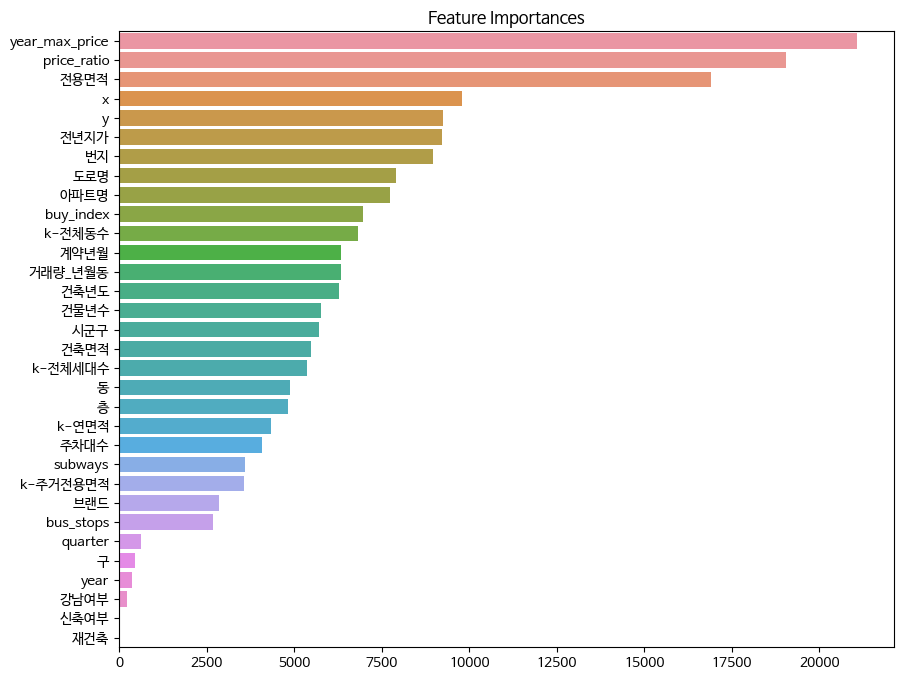

In [1075]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [1076]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open(f'model/saved_lgbm_model_{filename}.pkl', 'wb') as f:
    pickle.dump(best_model, f)

### 5.3. Feature selection

- 어떤 변수가 유용한 변수인지 확인해보기 위해 permutation selection을 이용해보겠습니다.

In [1077]:
%%time
# 4분 소요
# Permutation importance 방법을 변수 선택에 이용해보겠습니다.
# perm = PermutationImportance(best_model,        # 위에서 학습된 모델을 이용하겠습니다.
#                              scoring = "neg_mean_squared_error",        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
#                              random_state = 42,
#                              n_iter=3).fit(X_val, y_val)
# eli5.show_weights(perm, feature_names = X_val.columns.tolist())    # valid data에 대해 적합시킵니다.

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.3 µs


- 분석 결과 "계약년", "전용면적" 변수가 유의한 변수로 보입니다. 따라서 이 변수로 또 다른 파생변수를 더 생성해보거나, 중요도가 낮아보이는 변수를 제거해 차원의 저주를 막아볼 수도 있습니다.

### 5.4. Valid prediction 분석

- 예측값을 분석해보기 위해 valid prediction을 확인해보겠습니다.

In [1078]:
# Validation dataset에 target과 pred 값을 채워주도록 하겠습니다.
X_val['target'] = y_val
X_val['pred'] = preds

In [1079]:
# Squared_error를 계산하는 함수를 정의하겠습니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# RMSE 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors

In [1080]:
# Error가 큰 순서대로 sorting 해 보겠습니다.
X_val_sort = X_val.sort_values(by='error', ascending=False)       # 내림차순 sorting

In [1081]:
X_val_sort.head()

,시군구,번지,아파트명,전용면적,계약년월,층,건축년도,도로명,k-전체동수,k-전체세대수,...,신축여부,재건축,거래량_년월동,브랜드,건물년수,year_max_price,price_ratio,target,pred,error
11566,126,3543,1646,106.26,21,3,1973,3590,11.410448,955.208955,...,0,1,1,27,49,545000.0,0.020183,534000.000000,504247.013895,8.852402e+08
11570,126,3543,1646,106.26,24,2,1973,3590,11.440299,958.472637,...,0,1,19,27,50,482000.0,0.054633,455666.666667,480152.877861,5.995745e+08
11577,126,3543,1646,106.26,26,3,1973,3590,11.492537,964.184080,...,0,1,26,27,50,482000.0,0.054633,455666.666667,479760.713856,5.805231e+08
28359,126,1188,2804,112.93,12,3,2016,3592,15.000000,1612.000000,...,1,0,7,0,6,540000.0,0.046296,515000.000000,495897.026824,3.649236e+08
32753,234,1653,4076,101.95,10,1,1971,4786,4.026586,221.677341,...,0,1,9,0,50,350000.0,0.157143,295000.000000,313650.961703,3.478584e+08


- 예측을 잘 하지 못한 top 100개의 데이터와 예측을 잘한 top 100개의 데이터를 비교해보겠습니다.

In [1082]:
X_val_sort_top100 = X_val.sort_values(by='error', ascending=False).head(100)        # 예측을 잘 하지못한 top 100개의 data
X_val_sort_tail100 = X_val.sort_values(by='error', ascending=False).tail(100)       # 예측을 잘한 top 100개의 data

In [1083]:
# 해석을 위해 레이블인코딩 된 변수를 복원해줍니다.
error_top100 = X_val_sort_top100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    error_top100[column] = label_encoders[column].inverse_transform(X_val_sort_top100[column])

best_top100 = X_val_sort_tail100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    best_top100[column] = label_encoders[column].inverse_transform(X_val_sort_tail100[column])

In [1084]:
display(error_top100.head(1))
display(best_top100.head(1))

,시군구,번지,아파트명,전용면적,계약년월,층,건축년도,도로명,k-전체동수,k-전체세대수,...,신축여부,재건축,거래량_년월동,브랜드,건물년수,year_max_price,price_ratio,target,pred,error
11566,서울특별시 서초구 반포동,757,반포주공1단지,106.26,202210,3,1973,신반포로 45,11.410448,955.208955,...,0,1,1,주공,49,545000.0,0.020183,534000.0,504247.013895,8.852402e+08


,시군구,번지,아파트명,전용면적,계약년월,층,건축년도,도로명,k-전체동수,k-전체세대수,...,신축여부,재건축,거래량_년월동,브랜드,건물년수,year_max_price,price_ratio,target,pred,error
47624,서울특별시 노원구 상계동,647,상계주공12,41.3,202101,8,1988,한글비석로 530,8.221519,587.986551,...,0,1,267,주공,33,62000.0,0.131123,53870.37037,53871.468825,1.206603


- 이제 분포를 비교해보도록 하겠습니다.

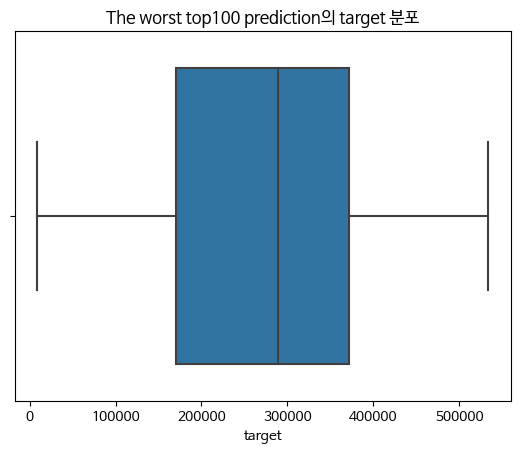

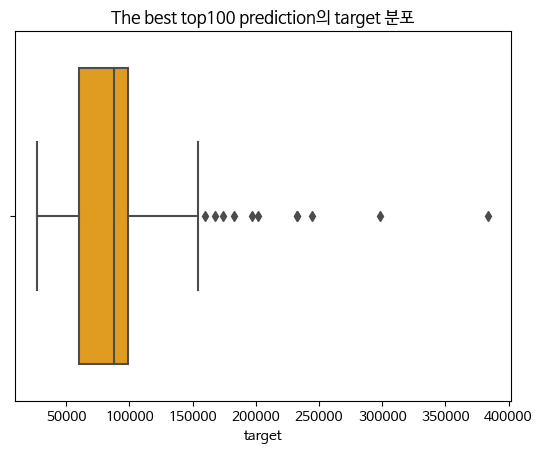

In [1085]:
sns.boxplot(data = error_top100, x='target')
plt.title('The worst top100 prediction의 target 분포')
plt.show()

sns.boxplot(data = best_top100, x='target', color='orange')
plt.title('The best top100 prediction의 target 분포')
plt.show()

- Taget 분포를 보니 좋은 예측을 보인 top 100개의 data보다 상대적으로 나쁜 예측을 보인 top 100 dataset들이 높은 가격을 보였음을 확인할 수 있습니다. 이에 대한 모델링 및 처리가 필요해보입니다.

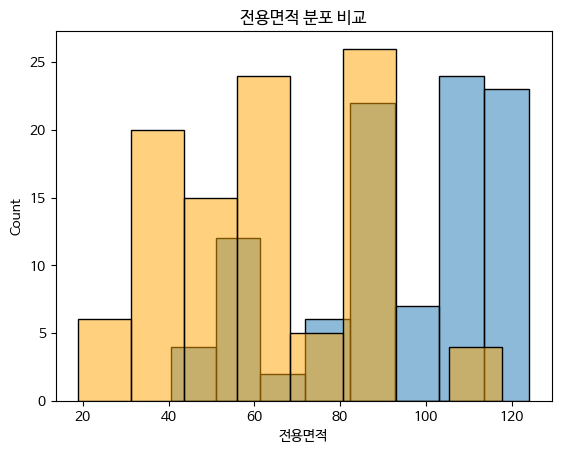

In [1086]:
sns.histplot(data = error_top100, x='전용면적', alpha=0.5)
sns.histplot(data = best_top100, x='전용면적', color='orange', alpha=0.5)
plt.title('전용면적 분포 비교')
plt.show()

- 전용면적 또한 나쁜 예측을 보인 집들이 더 넓음을 확인할 수 있습니다.

In [1087]:
list_count = 200
X_val_sort_top1000 = X_val.sort_values(by='error', ascending=False).head(list_count)        # 예측을 잘 하지못한 top 100개의 data

error_top1000 = X_val_sort_top1000.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    error_top1000[column] = label_encoders[column].inverse_transform(X_val_sort_top1000[column])

error_top1000.to_csv(f"output/worst_data_{filename}.csv", encoding='EUC-KR')

## 6. Inference

In [1088]:
dt_test.head(2)      # test dataset에 대한 inference를 진행해보겠습니다.

,시군구,번지,아파트명,전용면적,계약년월,층,건축년도,도로명,k-전체동수,k-전체세대수,...,buy_index,전년지가,강남여부,신축여부,재건축,거래량_년월동,브랜드,건물년수,year_max_price,price_ratio
72879,0,3145,241,79.9700,30,5,1987,3988,8.0,270.0,...,156.2,2.016696e+07,1,0,1,42,23,36,88000.0,0.0
72880,0,3124,242,108.2017,31,10,2021,292,2.0,232.0,...,163.5,2.016696e+07,1,1,0,40,6,2,88000.0,0.0


In [1089]:
# 저장된 모델을 불러옵니다.
with open(f'model/saved_lgbm_model_{filename}.pkl', 'rb') as f:
    model = pickle.load(f)

In [1090]:
dt_test.shape

(9272, 33)

In [1091]:
%%time
X_test = dt_test.drop(['target'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model.predict(X_test)

CPU times: user 682 ms, sys: 0 ns, total: 682 ms
Wall time: 76 ms


In [1092]:
real_test_pred          # 예측값들이 출력됨을 확인할 수 있습니다.

array([93220.91558266, 97652.77901954, 95637.82866199, ...,
       88289.5304813 , 77740.44102919, 87246.58155849])

## 7. Output File Save

In [1093]:

# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv(f'output/output_{filename}.csv', index=False)

In [1094]:
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    dt_test[column] = label_encoders[column].inverse_transform(dt_test[column])
pd.concat([dt_test, preds_df],axis=1).to_csv(f'output/predict_{filename}.csv', index=False, encoding='EUC-KR')

In [1095]:
#cond1 = concat_select['아파트명'] == '시영1'
#cond2 = concat_select['전용면적'] == 40.09
#cond3 = concat_select['층'] == 4
#concat_select[cond1 & cond2 & cond3].to_csv('output/temp_eda.csv', encoding='EUC-KR')

In [1096]:
drop_list = [138, 537, 599, 1138, 1284, 1481, 2741, 2781, 2814, 4031,
            5266, 6617, 9744, 10640, 13080, 13928, 17774, 18144, 18623, 26020,
            27544, 28441, 32948, 35932, 36769, 37152, 37507, 37943, 44141, 44152, 
            46756, 47683, 47684, 48333, 48713, 50357, 50465, 52597, 55418, 55447, 
            55490, 57063, 57078, 65175, 66608, 66658,  84581, 604063, 643457, 646233, 
            655888, 656518, 656621, 656674, 656682, 657279, 664237, 664255, 674574, 675089, 
            684520, 687127, 688566, 688624, 690021, 694421, 695584, 695666, 707992, 814850, 
            820959, 825602, 840939, 848353, 848569, 897069, 962284, 965892, 966318, 967783, 
            968557, 970525, 976360, 1007780, 1021798, 1066054, 1066130, 1066511, 1066520, 1066901, 
            1068519, 1068996, 1085349, 1099323, 1099324, 1099895, 1106086, 1112623, 1112689, 1123216 ]